# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### Constants

In [3]:
spain_region_country_name = "Spain"
spain_region_country_code = "ES"

daily_summary_days = 7 * 3
daily_plot_days = 7 * 2
tek_dumps_load_limit = daily_summary_days + 1

### COVID-19 Cases

In [4]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")

radar_covid_countries = {spain_region_country_name}

confirmed_df = confirmed_df[confirmed_df["Country_EN"].isin(radar_covid_countries)]
confirmed_df = confirmed_df[pd.isna(confirmed_df.Region)]
confirmed_df.head()

,Country_EN,Country_ES,Country_IT,Region,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22
218,Spain,España,Spagna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,566326.0,593730.0,603167.0,614360.0,625651.0,640040.0,640040.0,640040.0,671468.0,682267.0


In [5]:
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df.head()

,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22
218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,566326.0,593730.0,603167.0,614360.0,625651.0,640040.0,640040.0,640040.0,671468.0,682267.0


In [6]:
confirmed_df = confirmed_df.sum().to_frame()
confirmed_df.tail()

,0
2020-09-18,640040.0
2020-09-19,640040.0
2020-09-20,640040.0
2020-09-21,671468.0
2020-09-22,682267.0


In [7]:
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
239,2020-09-18,640040.0,14389.0,10531.0
240,2020-09-19,640040.0,0.0,10531.0
241,2020-09-20,640040.0,0.0,10531.0
242,2020-09-21,671468.0,31428.0,11105.0
243,2020-09-22,682267.0,10799.0,11300.0


In [8]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.covid_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)

confirmed_df["covid_cases"] = confirmed_df.covid_cases.fillna(0).astype(int)
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
240,2020-09-19,640040.0,0.0,10531
241,2020-09-20,640040.0,0.0,10531
242,2020-09-21,671468.0,31428.0,11105
243,2020-09-22,682267.0,10799.0,11300
243,2020-09-23,693567.0,11300.0,11300


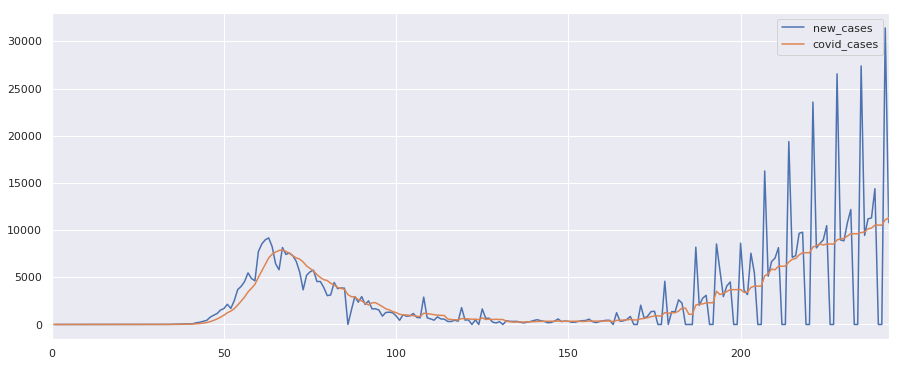

In [9]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [10]:
from Modules.RadarCOVID import radar_covid

raw_zip_paths = [
    "Data/TEKs/Raw/Current/RadarCOVID-TEKs-{sample_date}.zip",
    f"Data/TEKs/Raw/Daily/{extraction_date}/RadarCOVID-TEKs-{{sample_date}}.zip",
    f"Data/TEKs/Raw/Hourly/{extraction_date_with_hour}/RadarCOVID-TEKs-{{sample_date}}.zip",
]

multi_region_exposure_keys_df = \
    radar_covid.download_last_radar_covid_exposure_keys(
        days=14, save_raw_zip_path=raw_zip_paths)
multi_region_exposure_keys_df = multi_region_exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]]
multi_region_exposure_keys_df.head()

,sample_date_string,source_url,region,key_data
0,2020-09-22,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,d838916e-7268-48f2-e621-c0a7213ea17f
1,2020-09-22,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,ceca8c6c-a7ba-00ab-2dbc-142db01e000f
2,2020-09-22,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,62eff46b-2fa4-1129-e0ac-80b16b6def3e
3,2020-09-22,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,a754dc2f-660c-3325-6860-aa5c6b720a9e
4,2020-09-22,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,03976bef-7901-f0b0-bc38-348b6c993f7e


In [11]:
active_regions = \
    multi_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['ES']

In [12]:
multi_region_summary_df = multi_region_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_region_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
multi_region_summary_df.head()

,shared_teks_by_generation_date
region,ES
sample_date_string,
2020-09-22,16
2020-09-21,56
2020-09-20,72
2020-09-19,110
2020-09-18,120


In [13]:
multi_region_without_spain_exposure_keys_df = \
    multi_region_exposure_keys_df[multi_region_exposure_keys_df.region != spain_region_country_code]
active_regions_excluding_spain = \
    multi_region_without_spain_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions_excluding_spain

[]

In [14]:
exposure_keys_summary_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.region == spain_region_country_code]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df

,shared_teks_by_generation_date
sample_date_string,
2020-09-22,16
2020-09-21,56
2020-09-20,72
2020-09-19,110
2020-09-18,120
2020-09-17,139
2020-09-16,119
2020-09-15,82
2020-09-14,73


### Dump API TEKs

In [15]:
tek_list_df = multi_region_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour
tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    "Data/TEKs/Current/RadarCOVID-TEKs.json",
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-09-10,ES,"[6954f38b-22cd-d093-f288-7cdb50f2951d, 1a86957...",2020-09-23,2020-09-23@02
1,2020-09-11,ES,"[01db2363-8b7e-6bbd-a02c-d6b8db0aedaa, 9c07934...",2020-09-23,2020-09-23@02
2,2020-09-12,ES,"[30f2c790-b461-745c-60fb-1e002f4c94aa, 9d4da2c...",2020-09-23,2020-09-23@02
3,2020-09-13,ES,"[a4b3ef9b-86d2-1fb8-b525-e19eb3f4e068, 8b84121...",2020-09-23,2020-09-23@02
4,2020-09-14,ES,"[ffc37730-2cba-1530-9f70-355e55fabd8d, e63eb79...",2020-09-23,2020-09-23@02


### Load TEK Dumps

In [16]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    paths = list(reversed(sorted(glob.glob(f"Data/TEKs/{mode}/RadarCOVID-TEKs-*.json"))))
    if limit:
        paths = paths[:limit]
    for path in paths:
        logging.info(f"Loading TEKs from '{path}'...")
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [17]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=spain_region_country_code,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date
0,ES,2020-09-10,"[6954f38b-22cd-d093-f288-7cdb50f2951d, 1a86957...",2020-09-23
1,ES,2020-09-11,"[01db2363-8b7e-6bbd-a02c-d6b8db0aedaa, 9c07934...",2020-09-23
2,ES,2020-09-12,"[30f2c790-b461-745c-60fb-1e002f4c94aa, 9d4da2c...",2020-09-23
3,ES,2020-09-13,"[a4b3ef9b-86d2-1fb8-b525-e19eb3f4e068, 8b84121...",2020-09-23
4,ES,2020-09-14,"[ffc37730-2cba-1530-9f70-355e55fabd8d, e63eb79...",2020-09-23


In [18]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-09-22,16
2020-09-21,56
2020-09-20,72
2020-09-19,110
2020-09-18,120


### Daily New TEKs

In [19]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-09-02,"{b2b8ec8c-495f-d8e7-c82d-b245fab4d5a7, 3bbcdac..."
2020-09-03,"{b2b8ec8c-495f-d8e7-c82d-b245fab4d5a7, 3bbcdac..."
2020-09-04,"{b2b8ec8c-495f-d8e7-c82d-b245fab4d5a7, 3bbcdac..."
2020-09-05,"{b2b8ec8c-495f-d8e7-c82d-b245fab4d5a7, 3bbcdac..."
2020-09-06,"{3a1b03f8-cb24-bb90-f908-caa8be29e64e, b2b8ec8..."


In [20]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
17,2020-09-19,90.0
18,2020-09-20,116.0
19,2020-09-21,190.0
20,2020-09-22,148.0
21,2020-09-23,20.0


In [21]:
estimated_shared_diagnoses_df = daily_extracted_teks_df.copy()
estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
estimated_shared_diagnoses_df["extraction_date"] = pd.to_datetime(estimated_shared_diagnoses_df.extraction_date)
estimated_shared_diagnoses_df["sample_date"] = pd.to_datetime(estimated_shared_diagnoses_df.sample_date)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date
0,ES,2020-09-10,"[6954f38b-22cd-d093-f288-7cdb50f2951d, 1a86957...",2020-09-23,2020-09-11
1,ES,2020-09-11,"[01db2363-8b7e-6bbd-a02c-d6b8db0aedaa, 9c07934...",2020-09-23,2020-09-12
2,ES,2020-09-12,"[30f2c790-b461-745c-60fb-1e002f4c94aa, 9d4da2c...",2020-09-23,2020-09-13
3,ES,2020-09-13,"[a4b3ef9b-86d2-1fb8-b525-e19eb3f4e068, 8b84121...",2020-09-23,2020-09-14
4,ES,2020-09-14,"[ffc37730-2cba-1530-9f70-355e55fabd8d, e63eb79...",2020-09-23,2020-09-15


In [22]:
# Sometimes TEKs from the same day are uploaded, we do not count them as new TEK devices:
same_day_tek_list_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.sample_date == estimated_shared_diagnoses_df.extraction_date].copy()
same_day_tek_list_df = same_day_tek_list_df[["extraction_date", "tek_list"]].rename(
    columns={"tek_list": "same_day_tek_list"})
same_day_tek_list_df["extraction_date"] = \
    same_day_tek_list_df.extraction_date + datetime.timedelta(1)
same_day_tek_list_df.head()

,extraction_date,same_day_tek_list
13,2020-09-20,"[d4787a07-8b0b-58cc-b9e3-a94b0928d497, fc2611d..."
13,2020-09-19,[754bc832-e952-f047-e72d-5297ad25a4a7]


In [23]:
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.new_sample_extraction_date == estimated_shared_diagnoses_df.extraction_date]
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date
12,ES,2020-09-22,"[d838916e-7268-48f2-e621-c0a7213ea17f, ceca8c6...",2020-09-23,2020-09-23
12,ES,2020-09-21,"[35f895cd-d3df-9152-0889-804867c0685a, b5acdeb...",2020-09-22,2020-09-22
12,ES,2020-09-20,"[1f8f1e87-cd12-a94f-7e26-ef4ad246661b, 63d947d...",2020-09-21,2020-09-21
12,ES,2020-09-19,"[3218970f-4c82-daf4-6cb1-7d8d5877f484, 2d12869...",2020-09-20,2020-09-20
12,ES,2020-09-18,"[929af33f-4c54-9b8a-cf3a-a6eafed8dd0e, 8c6b618...",2020-09-19,2020-09-19


In [24]:
estimated_shared_diagnoses_df = \
    estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
estimated_shared_diagnoses_df["same_day_tek_list"] = \
    estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date,same_day_tek_list
0,ES,2020-09-22,"[d838916e-7268-48f2-e621-c0a7213ea17f, ceca8c6...",2020-09-23,2020-09-23,[]
1,ES,2020-09-21,"[35f895cd-d3df-9152-0889-804867c0685a, b5acdeb...",2020-09-22,2020-09-22,[]
2,ES,2020-09-20,"[1f8f1e87-cd12-a94f-7e26-ef4ad246661b, 63d947d...",2020-09-21,2020-09-21,[]
3,ES,2020-09-19,"[3218970f-4c82-daf4-6cb1-7d8d5877f484, 2d12869...",2020-09-20,2020-09-20,"[d4787a07-8b0b-58cc-b9e3-a94b0928d497, fc2611d..."
4,ES,2020-09-18,"[929af33f-4c54-9b8a-cf3a-a6eafed8dd0e, 8c6b618...",2020-09-19,2020-09-19,[754bc832-e952-f047-e72d-5297ad25a4a7]


In [25]:
estimated_shared_diagnoses_df.set_index("extraction_date", inplace=True)
estimated_shared_diagnoses_df["shared_diagnoses"] = estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1).copy()
estimated_shared_diagnoses_df.reset_index(inplace=True)
estimated_shared_diagnoses_df.rename(columns={
    "extraction_date": "sample_date_string"}, inplace=True)
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[["sample_date_string", "shared_diagnoses"]]
estimated_shared_diagnoses_df["sample_date_string"] = estimated_shared_diagnoses_df.sample_date_string.dt.strftime("%Y-%m-%d")
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
0,2020-09-23,16
1,2020-09-22,55
2,2020-09-21,45
3,2020-09-20,45
4,2020-09-19,39


### Hourly New TEKs

In [26]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=spain_region_country_code, limit=25)
hourly_extracted_teks_df.head()

hourly_tek_list_df = hourly_extracted_teks_df.groupby("extraction_date_with_hour").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
hourly_tek_list_df = hourly_tek_list_df.set_index("extraction_date_with_hour").sort_index(ascending=True)

hourly_new_tek_df = hourly_tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
hourly_new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_df.tail()

,extraction_date_with_hour,shared_teks_by_upload_date
20,2020-09-22@22,0.0
21,2020-09-22@23,0.0
22,2020-09-23@00,0.0
23,2020-09-23@01,0.0
24,2020-09-23@02,20.0


In [27]:
hourly_new_tek_devices_df = hourly_extracted_teks_df.copy()
hourly_new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_new_tek_devices_df.sample_date) + datetime.timedelta(1)
hourly_new_tek_devices_df["extraction_date"] = pd.to_datetime(hourly_new_tek_devices_df.extraction_date)

hourly_new_tek_devices_df = hourly_new_tek_devices_df[
    hourly_new_tek_devices_df.new_sample_extraction_date == hourly_new_tek_devices_df.extraction_date]

hourly_new_tek_devices_df.set_index("extraction_date_with_hour", inplace=True)
hourly_new_tek_devices_df_ = pd.DataFrame()

for i, chunk_df in hourly_new_tek_devices_df.groupby("extraction_date"):
    chunk_df = chunk_df.copy()
    chunk_df.sort_index(inplace=True)
    chunk_tek_count_df = chunk_df.tek_list.apply(lambda x: len(set(x)))
    chunk_df = chunk_tek_count_df.diff().fillna(chunk_tek_count_df).to_frame()
    hourly_new_tek_devices_df_ = hourly_new_tek_devices_df_.append(chunk_df)
    
hourly_new_tek_devices_df = hourly_new_tek_devices_df_
hourly_new_tek_devices_df.reset_index(inplace=True)
hourly_new_tek_devices_df.rename(columns={
    "tek_list": "shared_diagnoses"}, inplace=True)
hourly_new_tek_devices_df.tail()

,extraction_date_with_hour,shared_diagnoses
17,2020-09-22@20,4.0
18,2020-09-22@21,0.0
19,2020-09-22@22,0.0
20,2020-09-22@23,0.0
21,2020-09-23@02,16.0


In [28]:
hourly_summary_df = hourly_new_tek_df.merge(
    hourly_new_tek_devices_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.tail()

,extraction_date_with_hour,shared_teks_by_upload_date,shared_diagnoses
datetime_utc,,,
2020-09-22 22:00:00,2020-09-22@22,0.0,0.0
2020-09-22 23:00:00,2020-09-22@23,0.0,0.0
2020-09-23 00:00:00,2020-09-23@00,0.0,NaN
2020-09-23 01:00:00,2020-09-23@01,0.0,NaN
2020-09-23 02:00:00,2020-09-23@02,20.0,16.0


### Data Merge

In [29]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-09-22,16.0,148.0
1,2020-09-21,56.0,190.0
2,2020-09-20,72.0,116.0
3,2020-09-19,110.0,90.0
4,2020-09-18,120.0,138.0


In [30]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses
0,2020-09-22,16.0,148.0,55.0
1,2020-09-21,56.0,190.0,45.0
2,2020-09-20,72.0,116.0,45.0
3,2020-09-19,110.0,90.0,39.0
4,2020-09-18,120.0,138.0,52.0


In [31]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses
0,2020-09-03,488513.0,8959.0,8429,51.0,49.0,19.0
1,2020-09-04,498989.0,10476.0,8529,52.0,58.0,20.0
2,2020-09-05,498989.0,0.0,8529,56.0,40.0,17.0
3,2020-09-06,498989.0,0.0,8529,54.0,60.0,24.0
4,2020-09-07,525549.0,26560.0,8956,58.0,52.0,22.0


In [32]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses
sample_date,,,,,,
2020-09-23,693567.0,11300.0,11300,NaN,20.0,16.0
2020-09-22,682267.0,10799.0,11300,16.0,148.0,55.0
2020-09-21,671468.0,31428.0,11105,56.0,190.0,45.0
2020-09-20,640040.0,0.0,10531,72.0,116.0,45.0
2020-09-19,640040.0,0.0,10531,110.0,90.0,39.0


In [33]:
result_summary_df = result_summary_df.fillna(0).astype(int)
result_summary_df["teks_per_shared_diagnosis"] = \
    result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses
result_summary_df["shared_diagnoses_per_covid_case"] = \
    result_summary_df.shared_diagnoses / result_summary_df.covid_cases
result_summary_df.head()

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,
2020-09-23,693567,11300,11300,0,20,16,1.250000,0.001416
2020-09-22,682267,10799,11300,16,148,55,2.690909,0.004867
2020-09-21,671468,31428,11105,56,190,45,4.222222,0.004052
2020-09-20,640040,0,10531,72,116,45,2.577778,0.004273
2020-09-19,640040,0,10531,110,90,39,2.307692,0.003703


In [34]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)
weekly_result_summary_df["teks_per_shared_diagnosis"] = \
    weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses
weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
    weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases
weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-09-23,75513.0,513.0,765.0,281.0,2.722420,0.003721
2020-09-22,74353.0,632.0,807.0,288.0,2.802083,0.003873
2020-09-21,72861.0,698.0,717.0,256.0,2.800781,0.003514
2020-09-20,71496.0,715.0,588.0,239.0,2.460251,0.003343
2020-09-19,70585.0,718.0,564.0,226.0,2.495575,0.003202


In [35]:
last_7_days_summary = weekly_result_summary_df.iloc[0]
last_7_days_summary

covid_cases                        75513.000000
shared_teks_by_generation_date       513.000000
shared_teks_by_upload_date           765.000000
shared_diagnoses                     281.000000
teks_per_shared_diagnosis              2.722420
shared_diagnoses_per_covid_case        0.003721
Name: 2020-09-23 00:00:00, dtype: float64

## Report Results

In [36]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "datetime_utc": "Timestamp (UTC)",
    "covid_cases": "COVID-19 Cases (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases Which Shared Diagnosis)",
}

### Daily Summary Table

In [37]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[[
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case"]]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases Which Shared Diagnosis)
Sample Date (UTC),,,,,,
2020-09-23,11300,0,20,16,1.250000,0.001416
2020-09-22,11300,16,148,55,2.690909,0.004867
2020-09-21,11105,56,190,45,4.222222,0.004052
2020-09-20,10531,72,116,45,2.577778,0.004273
2020-09-19,10531,110,90,39,2.307692,0.003703
2020-09-18,10531,120,138,52,2.653846,0.004938
2020-09-17,10215,139,63,29,2.172414,0.002839
2020-09-16,10140,119,62,23,2.695652,0.002268
2020-09-15,9808,82,58,23,2.521739,0.002345


### Daily Summary Plots

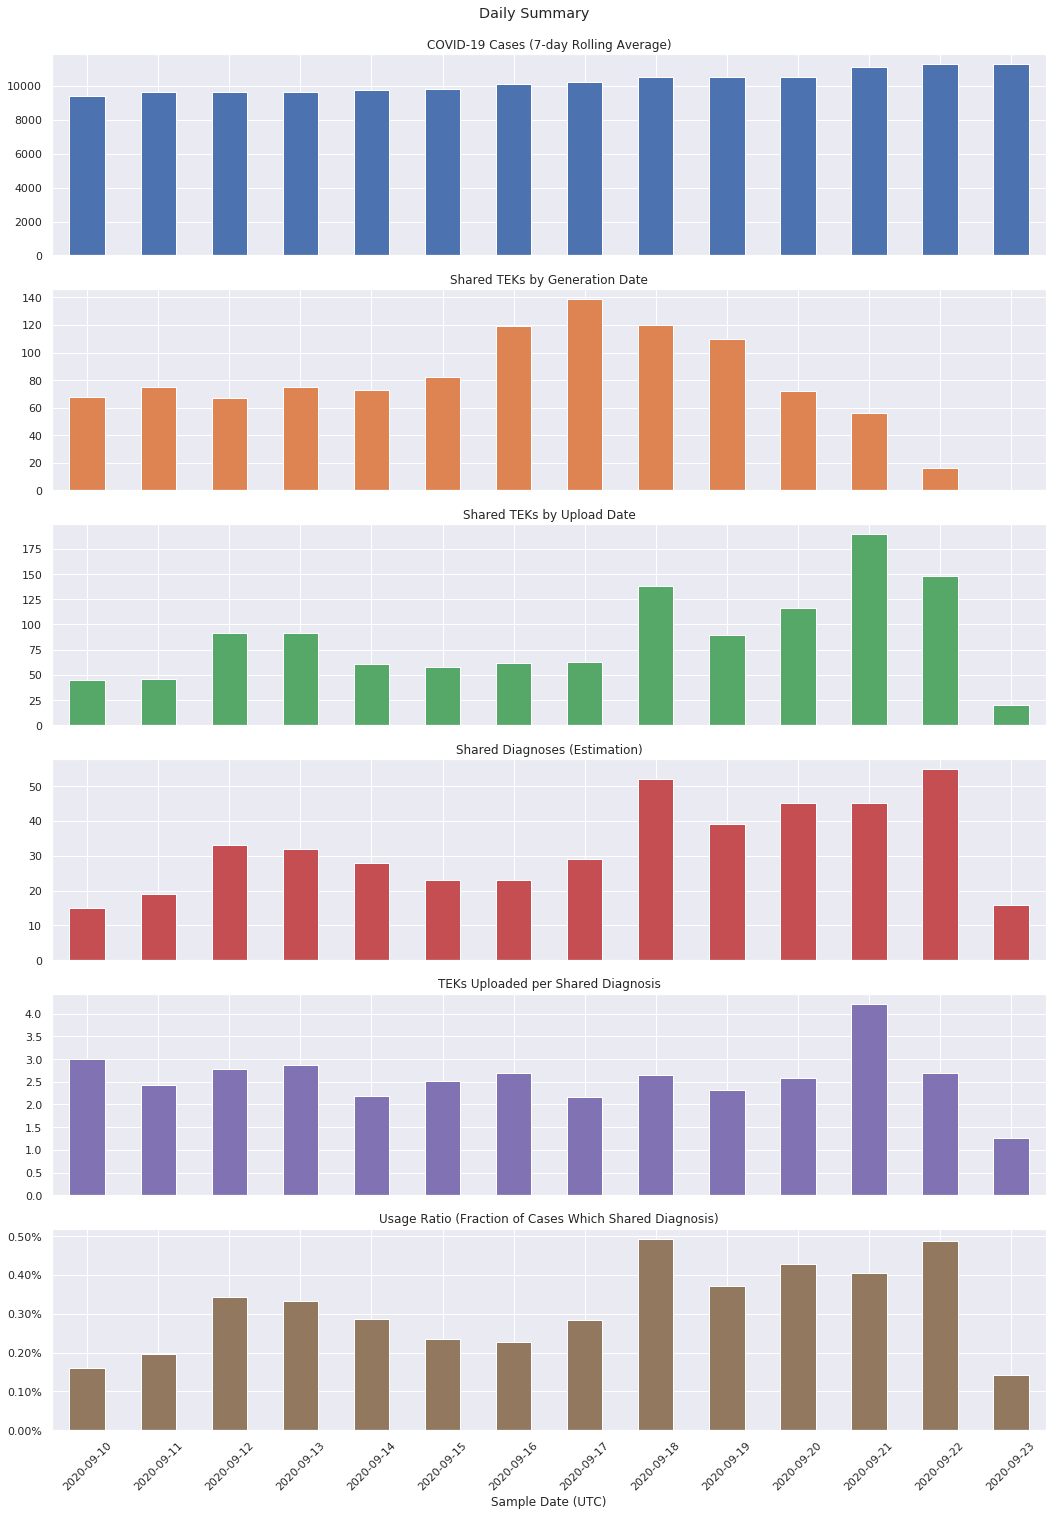

In [38]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[[
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case"]] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Hourly Summary Plots 

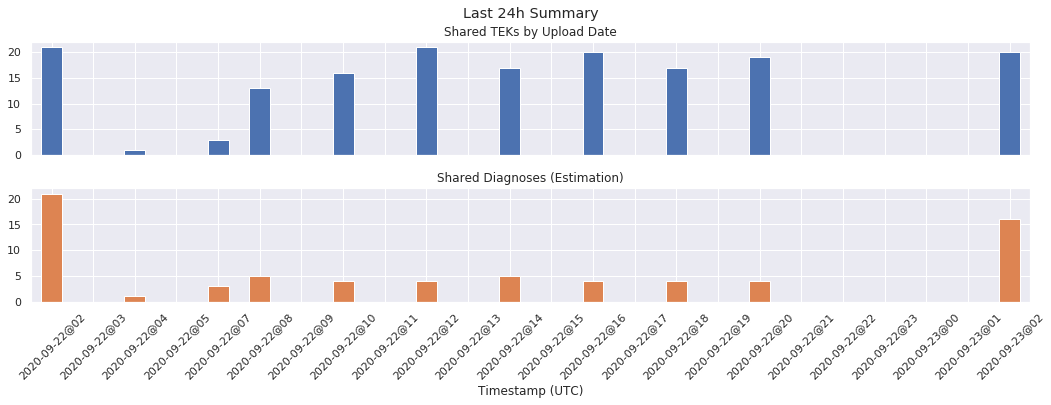

In [39]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [40]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [41]:
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(
        formatters={
            display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
            display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
        })

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)
shared_diagnoses_last_hour = \
    extraction_date_result_hourly_summary_df.shared_diagnoses.sum().astype(int)

In [42]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_region_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_region_summary_df)

### Save Results

In [43]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(report_resources_path_prefix + "Summary-Table.html")
multi_region_summary_df.to_csv(report_resources_path_prefix + "Multi-Region-Summary-Table.csv")
_ = shutil.copyfile(summary_plots_image_path, report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(summary_table_image_path, report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(hourly_summary_plots_image_path, report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(multi_region_summary_table_image_path, report_resources_path_prefix + "Multi-Region-Summary-Table.png")

report_daily_url_pattern = \
    "https://github.com/pvieito/RadarCOVID-Report/blob/master/Notebooks/" \
    "RadarCOVID-Report/{report_type}/RadarCOVID-Report-{report_date}.ipynb"
report_daily_url = report_daily_url_pattern.format(
    report_type="Daily", report_date=extraction_date)
report_hourly_url = report_daily_url_pattern.format(
    report_type="Hourly", report_date=extraction_date_with_hour)

### Publish Results as JSON

In [44]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=shared_diagnoses_last_hour,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=dict(
        covid_cases=last_7_days_summary.covid_cases,
        shared_teks_by_upload_date=last_7_days_summary.shared_teks_by_upload_date,
        shared_diagnoses=last_7_days_summary.shared_diagnoses,
        teks_per_shared_diagnosis=last_7_days_summary.teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=last_7_days_summary.shared_diagnoses_per_covid_case,
    ),
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [45]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    daily_summary_table_html=daily_summary_table_html,
    report_url_with_hour=report_hourly_url,
    extraction_date_with_hour=extraction_date_with_hour)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [46]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    hourly_summary_plots_media = api.media_upload(hourly_summary_plots_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        hourly_summary_plots_media.media_id,
    ]

    status = textwrap.dedent(f"""
        #RadarCOVID Report – {extraction_date_with_hour}

        Today:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: {shared_diagnoses:.0f} ({shared_diagnoses_last_hour:+d} last hour)
        - TEKs per Diagnosis: {teks_per_shared_diagnosis:.2}
        - Usage Ratio: {shared_diagnoses_per_covid_case:.2%}

        Week:
        - Shared Diagnoses: {last_7_days_summary.shared_diagnoses:.0f}
        - Usage Ratio: {last_7_days_summary.shared_diagnoses_per_covid_case:.2%}

        Report Link: {report_hourly_url}
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)